# Module 8 — Exploratory Data Analysis (EDA) with SQL  
**Course:** CPSC 500 – SQL Databases • **DB:** `farmers_market`

This all‑in‑one notebook follows your Module 8 web pages exactly:
1. Introduction to EDA with SQL  
2. Exploring Key Database Tables in EDA  
3. Continuing to Explore Key Tables  
4. Exploring Column Values with Summary Statistics  
5. Time Series Analysis in Data Mining  
6. Exploring Data Across Multiple Tables  
7. Summary of EDA with SQL

## Setup — Connect to MySQL and helper

> Uses the same connection style we've used throughout the course (teaching only — never commit credentials).

In [ ]:
import mysql.connector
import pandas as pd

# Establish connection to local MySQL server
conn = mysql.connector.connect(
    host="localhost",
    user="root",       # teaching only; don't use root in production
    password="",   # replace with your secure secret
    database="farmers_market"
)
cursor = conn.cursor()
print(f"Connected to {conn.database}!")

def run_query(sql: str, params: tuple = None, preview: int = 10):
    """Execute a SQL query and return a DataFrame. Set preview=None to return full result."""
    cur = conn.cursor()
    cur.execute(sql, params or ())
    rows = cur.fetchall()
    cols = [d[0] for d in cur.description] if cur.description else []
    cur.close()
    df = pd.DataFrame(rows, columns=cols)
    return df.head(preview) if preview is not None else df

Connected to farmers_market!


---
## 1) Introduction to EDA with SQL

**Goal.** Use SQL to quickly **profile tables, columns, and relationships**, and to **surface patterns** that guide downstream analytics / ML.

**Checklist.**
- What tables exist and how big are they?
- What are the primary/foreign keys and critical columns?
- What ranges, distributions, and null rates do we see?
- How do entities behave over **time**?
- What do we learn when we combine multiple tables?

---
## 2) Exploring Key Database Tables in EDA
Start by listing tables in the schema and inspecting a few rows.

In [4]:
# List tables in the schema (works in MySQL 8+)
# This query retrieves the names and row counts of all tables in the 'farmers_market' schema.
# It uses the information_schema.tables system table to access metadata about the database.
# The results are ordered alphabetically by table name.
run_query("""
SELECT table_name, table_rows
FROM information_schema.tables
WHERE table_schema = 'farmers_market'
ORDER BY table_name;
""", preview=None)

,TABLE_NAME,TABLE_ROWS
0,booth,12
1,customer,26
2,customer_purchases,4221
3,market_date_info,150
4,product,23
5,product_category,7
6,vendor,9
7,vendor_booth_assignments,921
8,vendor_inventory,797
9,zip_data,3


In [5]:
# Row counts per table — reliable by counting primary key / a stable column
# This query calculates the number of rows in each table of the 'farmers_market' database.
# It uses a series of SELECT statements combined with UNION ALL to aggregate row counts for all tables.
# Each SELECT statement targets a specific table and counts its rows using the COUNT(*) function.
# The 'table_name' column is hardcoded for each table to label the results.
# UNION ALL ensures that the results from all SELECT statements are combined into a single output.
# This approach is particularly useful when the information_schema.tables metadata is unreliable.
run_query("""
SELECT 'booth' AS table_name, COUNT(*) AS rows_count FROM booth
UNION ALL
SELECT 'customer', COUNT(*) FROM customer
UNION ALL
SELECT 'customer_purchases', COUNT(*) FROM customer_purchases
UNION ALL
SELECT 'market_date_info', COUNT(*) FROM market_date_info
UNION ALL
SELECT 'product', COUNT(*) FROM product
UNION ALL
SELECT 'product_category', COUNT(*) FROM product_category
UNION ALL
SELECT 'vendor', COUNT(*) FROM vendor
UNION ALL
SELECT 'vendor_booth_assignments', COUNT(*) FROM vendor_booth_assignments
UNION ALL
SELECT 'vendor_inventory', COUNT(*) FROM vendor_inventory
UNION ALL
SELECT 'zip_data', COUNT(*) FROM zip_data;
""", preview=None)

,table_name,rows_count
0,booth,12
1,customer,26
2,customer_purchases,4221
3,market_date_info,150
4,product,23
5,product_category,7
6,vendor,9
7,vendor_booth_assignments,921
8,vendor_inventory,797
9,zip_data,3


In [10]:
# Peek at a few representative tables
# This section retrieves and displays sample rows from three key tables in the 'farmers_market' database.

# 1. The 'vendor' table:
#    - Retrieves all columns for the first 5 rows, ordered by 'vendor_id'.
#    - This provides a quick overview of the vendor data structure and sample values.
print("_____vendor_____")
display(run_query("SELECT * FROM vendor ORDER BY vendor_id LIMIT 5", preview=None))

# 2. The 'product' table:
#    - Retrieves all columns for the first 5 rows, ordered by 'product_id'.
#    - This helps understand the product catalog and its attributes.
print("\n_____product_____")
display(run_query("SELECT * FROM product ORDER BY product_id LIMIT 5", preview=None))

# 3. The 'customer_purchases' table:
#    - Selects specific columns related to transactions, such as market date, transaction time, customer ID, product ID, quantity, and cost.
#    - Orders the results by 'market_date' and 'transaction_time' to show the chronological sequence of purchases.
#    - Limits the output to the first 5 rows for a concise preview.
print("\n_____customer_purchases_____")
display(run_query("""
SELECT market_date, transaction_time, customer_id, product_id, quantity, cost_to_customer_per_qty
FROM customer_purchases
ORDER BY market_date, transaction_time
LIMIT 20
""", preview=None))

_____vendor_____


,vendor_id,vendor_name,vendor_type,vendor_owner_first_name,vendor_owner_last_name
0,1,Chris's Sustainable Eggs & Meats,Eggs & Meats,Chris,Sylvan
1,2,Hernández Salsa & Veggies,Fresh Variety: Veggies & More,Maria,Hernández
2,3,Mountain View Vegetables,Fresh Variety: Veggies & More,Joseph,Yoder
3,4,Fields of Corn,Fresh Focused,Samuel,Smith
4,5,Seashell Clay Shop,Arts & Jewelry,Karen,Soula



_____product_____


,product_id,product_name,product_size,product_category_id,product_qty_type
0,1,Habanero Peppers - Organic,medium,1,lbs
1,2,Jalapeno Peppers - Organic,small,1,lbs
2,3,Poblano Peppers - Organic,large,1,unit
3,4,Banana Peppers - Jar,8 oz,3,unit
4,5,Whole Wheat Bread,1.5 lbs,3,unit



_____customer_purchases_____


,market_date,transaction_time,customer_id,product_id,quantity,cost_to_customer_per_qty
0,2019-04-03,0 days 16:17:00,9,8,2.00,18.00
1,2019-04-03,0 days 16:20:00,9,7,1.00,18.00
2,2019-04-03,0 days 16:40:00,9,5,1.00,6.50
3,2019-04-03,0 days 17:08:00,9,7,2.00,18.00
4,2019-04-03,0 days 17:22:00,6,5,1.00,6.50
5,2019-04-03,0 days 17:24:00,9,5,1.00,6.50
6,2019-04-03,0 days 17:31:00,23,7,1.00,18.00
7,2019-04-03,0 days 17:35:00,23,7,2.00,18.00
8,2019-04-03,0 days 17:41:00,23,8,3.00,18.00
9,2019-04-03,0 days 17:59:00,7,4,5.00,4.00


**Interpretation.** We now know **what's available** (tables/row counts) and have an initial sense of the **columns and value shapes**.

---
## 3) Continuing to Explore Key Tables

Profile **keys, distincts, and nulls** to catch data‑quality issues early.

In [12]:
# Distinct counts (assortment breadth) and NULL counts for key columns
# This query profiles three key tables ('product', 'vendor', and 'customer_purchases') in the 'farmers_market' database.
# It calculates the following metrics for each table:
# 1. Total row count (`COUNT(*)`), aliased as `rows`.
# 2. Count of distinct values in a key column (e.g., `product_category_id`, `vendor_type`, `customer_id`).
# 3. Count of NULL values in a critical column (e.g., `product_name`, `vendor_name`, `cost_to_customer_per_qty`).
#
# The query uses `UNION ALL` to combine results from the three tables into a single output.
# Each SELECT statement targets a specific table and calculates the metrics described above.
# The alias `rows` is enclosed in backticks to avoid conflicts with MySQL reserved keywords.
run_query("""
SELECT 'product' AS tbl, COUNT(*) AS `rows`,
       COUNT(DISTINCT product_category_id) AS distinct_categories,
       SUM(CASE WHEN product_name IS NULL THEN 1 ELSE 0 END) AS null_product_name
FROM product
UNION ALL
SELECT 'vendor', COUNT(*),
       COUNT(DISTINCT vendor_type),
       SUM(CASE WHEN vendor_name IS NULL THEN 1 ELSE 0 END)
FROM vendor
UNION ALL
SELECT 'customer_purchases', COUNT(*),
       COUNT(DISTINCT customer_id),
       SUM(CASE WHEN cost_to_customer_per_qty IS NULL THEN 1 ELSE 0 END)
FROM customer_purchases;
""", preview=None)

,tbl,rows,distinct_categories,null_product_name
0,product,23,6,0
1,vendor,9,5,0
2,customer_purchases,4221,26,0


In [13]:
# Distribution examples: top product categories and vendor types

# 1. Top product categories:
#    - This query identifies the most common product categories in the 'product' table.
#    - It joins the 'product' table with the 'product_category' table using the foreign key 'product_category_id'.
#    - The results are grouped by 'product_category_name' and sorted by the count of products in descending order.
#    - The LIMIT clause restricts the output to the top 10 categories.
print("Top product categories")
display(run_query("""
SELECT pc.product_category_name, COUNT(*) AS num_products
FROM product AS p
JOIN product_category AS pc ON p.product_category_id = pc.product_category_id
GROUP BY pc.product_category_name
ORDER BY num_products DESC, pc.product_category_name
LIMIT 10;
""", preview=None))

# 2. Vendor types:
#    - This query counts the number of vendors for each vendor type in the 'vendor' table.
#    - The results are grouped by 'vendor_type' and sorted by the count of vendors in descending order.
print("\nVendor types")
display(run_query("""
SELECT vendor_type, COUNT(*) AS vendors
FROM vendor
GROUP BY vendor_type
ORDER BY vendors DESC, vendor_type;
""", preview=None))

Top product categories


,product_category_name,num_products
0,Fresh Fruits & Vegetables,13
1,Packaged Prepared Food,4
2,Eggs & Meat (Fresh or Frozen),2
3,Non-Edible Products,2
4,Packaged Pantry Goods,1
5,Plants & Flowers,1



Vendor types


,vendor_type,vendors
0,Fresh Variety: Veggies & More,3
1,Fresh Focused,2
2,Prepared Foods,2
3,Arts & Jewelry,1
4,Eggs & Meats,1


**Interpretation.** Distinct / NULL counts expose issues; simple distributions reveal **dominant categories or types**.

---
## 4) Exploring Column Values with Summary Statistics

Use summary stats to understand **ranges and central tendency**.  
For a numeric column \(x\): mean \(\mu = \frac{1}{n} \sum x_i\), min/max, and spread (e.g., percentiles).

In [14]:
# Price statistics (overall)
# This query calculates basic summary statistics for the 'cost_to_customer_per_qty' column in the 'customer_purchases' table.
#
# 1. MIN: Finds the minimum price paid by customers for any product, rounded to 2 decimal places.
# 2. MAX: Finds the maximum price paid by customers for any product, rounded to 2 decimal places.
# 3. AVG: Calculates the average price paid by customers for any product, rounded to 2 decimal places.
#
# These statistics provide an overview of the price range and central tendency for customer purchases.
run_query("""
SELECT
    ROUND(MIN(cost_to_customer_per_qty), 2) AS min_price,
    ROUND(MAX(cost_to_customer_per_qty), 2) AS max_price,
    ROUND(AVG(cost_to_customer_per_qty), 2) AS avg_price
FROM customer_purchases;
""", preview=None)

,min_price,max_price,avg_price
0,0.40,18.00,7.66


In [15]:
# Price statistics per product
# This query calculates summary statistics for the 'cost_to_customer_per_qty' column, grouped by product.
#
# 1. MIN: Finds the minimum price paid by customers for each product, rounded to 2 decimal places.
# 2. MAX: Finds the maximum price paid by customers for each product, rounded to 2 decimal places.
# 3. AVG: Calculates the average price paid by customers for each product, rounded to 2 decimal places.
#
# The query joins the 'product' table with the 'customer_purchases' table using the foreign key 'product_id'.
# Results are grouped by 'product_id' and 'product_name', and sorted by 'product_id' in ascending order.
# The LIMIT clause restricts the output to the first 15 rows for preview purposes.
run_query("""
SELECT
    p.product_id,
    p.product_name,
    ROUND(MIN(cp.cost_to_customer_per_qty), 2) AS min_price,
    ROUND(MAX(cp.cost_to_customer_per_qty), 2) AS max_price,
    ROUND(AVG(cp.cost_to_customer_per_qty), 2) AS avg_price
FROM product AS p
JOIN customer_purchases AS cp ON cp.product_id = p.product_id
GROUP BY p.product_id, p.product_name
ORDER BY p.product_id;
""", preview=15)

,product_id,product_name,min_price,max_price,avg_price
0,1,Habanero Peppers - Organic,6.99,6.99,6.99
1,2,Jalapeno Peppers - Organic,3.00,3.49,3.48
2,3,Poblano Peppers - Organic,0.50,0.50,0.50
3,4,Banana Peppers - Jar,3.50,4.00,3.94
4,5,Whole Wheat Bread,6.50,6.50,6.50
5,7,Apple Pie,18.00,18.00,18.00
6,8,Cherry Pie,18.00,18.00,18.00
7,16,Sweet Corn,0.40,0.50,0.49


In [16]:
# Quantity distribution by product (inventory table)
# This query calculates summary statistics for the 'quantity' column in the 'vendor_inventory' table, grouped by product.
#
# 1. AVG: Calculates the average quantity available for each product, rounded to 2 decimal places.
# 2. MIN: Finds the minimum quantity available for each product, rounded to 2 decimal places.
# 3. MAX: Finds the maximum quantity available for each product, rounded to 2 decimal places.
#
# The results are grouped by 'product_id' and sorted in ascending order of 'product_id'.
# The LIMIT clause restricts the output to the first 20 rows for preview purposes.
run_query("""
SELECT product_id,
       ROUND(AVG(quantity), 2) AS avg_qty,
       ROUND(MIN(quantity), 2) AS min_qty,
       ROUND(MAX(quantity), 2) AS max_qty
FROM vendor_inventory
GROUP BY product_id
ORDER BY product_id
LIMIT 20;
""", preview=None)

,product_id,avg_qty,min_qty,max_qty
0,1,10.15,6.29,15.49
1,2,29.36,17.29,36.98
2,3,65.66,50.00,80.00
3,4,36.83,30.00,40.00
4,5,20.07,15.00,25.00
5,7,8.25,5.00,28.00
6,8,8.06,5.00,27.00
7,16,195.00,100.00,300.00


**Interpretation.** These tables show price and quantity ranges. Outliers or very wide ranges may need **winsorization or deeper investigation** before modeling.

---
## 5) Time Series Analysis in Data Mining

Aggregate by date to reveal **trends**. Then use window functions for **running totals** and **moving averages**.

In [17]:
# Daily revenue (all vendors/products)
# This query calculates the total daily revenue generated from all vendors and products in the 'customer_purchases' table.
#
# 1. SUM: Multiplies the 'quantity' of each product by its 'cost_to_customer_per_qty' to calculate the revenue for each purchase.
#    - The IFNULL function ensures that any NULL values in 'cost_to_customer_per_qty' are treated as 0.
# 2. ROUND: Rounds the daily revenue to 2 decimal places for better readability.
#
# The results are grouped by 'market_date' to aggregate revenue for each day.
# The output is sorted in ascending order of 'market_date'.
run_query("""
SELECT
    market_date,
    ROUND(SUM(quantity * IFNULL(cost_to_customer_per_qty,0)), 2) AS revenue_day
FROM customer_purchases
GROUP BY market_date
ORDER BY market_date;
""", preview=15)

,market_date,revenue_day
0,2019-04-03,475.00
1,2019-04-06,549.50
2,2019-04-10,505.00
3,2019-04-13,377.00
4,2019-04-17,493.50
5,2019-04-20,455.50
6,2019-04-24,366.00
7,2019-04-27,444.50
8,2019-05-01,523.00
9,2019-05-04,497.00


### Extra, but to show the power of Python in visualization 

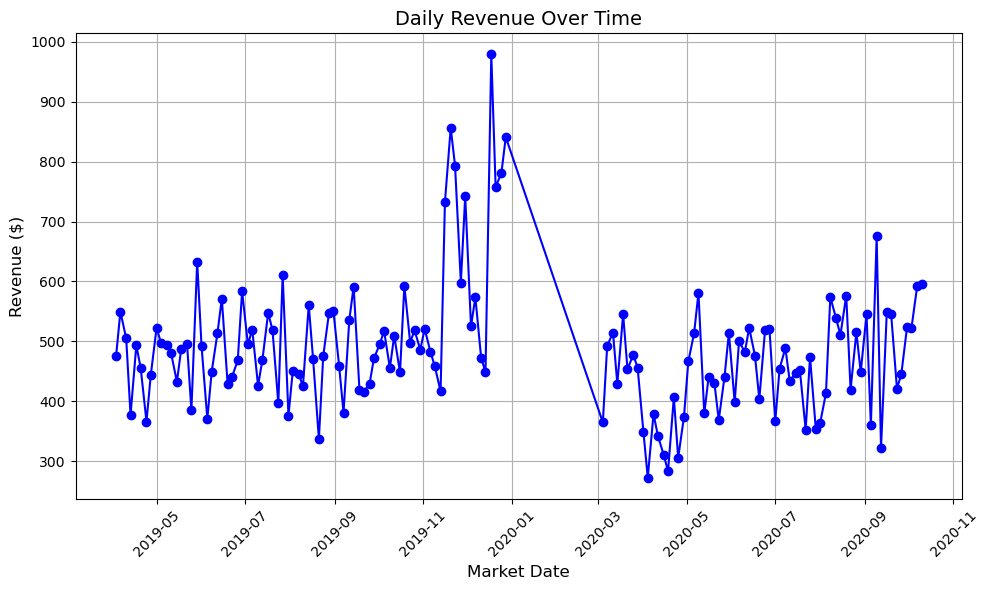

In [26]:
# Visualize daily revenue
# This code visualizes the daily revenue calculated in the previous cell using a line plot.
import matplotlib.pyplot as plt

daily_revenue = run_query("""
SELECT
    market_date,
    ROUND(SUM(quantity * IFNULL(cost_to_customer_per_qty,0)), 2) AS revenue_day
FROM customer_purchases
GROUP BY market_date
ORDER BY market_date;
""", preview=None)

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(daily_revenue['market_date'], daily_revenue['revenue_day'], marker='o', linestyle='-', color='b')
plt.title('Daily Revenue Over Time', fontsize=14)
plt.xlabel('Market Date', fontsize=12)
plt.ylabel('Revenue ($)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [27]:
# Running total revenue and 7-day moving average
# This query calculates two key metrics for daily revenue:
#
# 1. Running Total Revenue:
#    - Uses the SUM() window function with the ROWS UNBOUNDED PRECEDING clause.
#    - This calculates the cumulative revenue up to each market date.
#
# 2. 7-Day Moving Average:
#    - Uses the AVG() window function with the ROWS 6 PRECEDING clause.
#    - This calculates the average revenue over the current day and the previous 6 days.
#
# The query is structured as follows:
# - A Common Table Expression (CTE) named 'daily' calculates the total revenue for each market date.
# - The main query applies window functions to compute the running total and moving average.
# - Results are ordered by 'market_date' in ascending order.
run_query("""
WITH daily AS (
  SELECT
      market_date,
      SUM(quantity * IFNULL(cost_to_customer_per_qty,0)) AS rev
  FROM customer_purchases
  GROUP BY market_date
)
SELECT
    market_date,
    ROUND(rev, 2) AS revenue_day,
    ROUND(SUM(rev) OVER (ORDER BY market_date ROWS UNBOUNDED PRECEDING), 2) AS running_rev,
    ROUND(AVG(rev) OVER (ORDER BY market_date ROWS 6 PRECEDING), 2) AS ma7
FROM daily
ORDER BY market_date;
""", preview=20)

,market_date,revenue_day,running_rev,ma7
0,2019-04-03,475.00,475.00,475.00
1,2019-04-06,549.50,1024.50,512.25
2,2019-04-10,505.00,1529.50,509.83
3,2019-04-13,377.00,1906.50,476.63
4,2019-04-17,493.50,2400.00,480.00
5,2019-04-20,455.50,2855.50,475.92
6,2019-04-24,366.00,3221.50,460.21
7,2019-04-27,444.50,3666.00,455.86
8,2019-05-01,523.00,4189.00,452.07
9,2019-05-04,497.00,4686.00,450.93


**Interpretation.** Running totals show cumulative performance; moving averages smooth **short‑term noise** to highlight **trend**.

---
## 6) Exploring Data Across Multiple Tables

Join tables to enrich context and unlock multi‑dimensional insights.

In [29]:
# Revenue by vendor_type and product_category
# This query calculates the total revenue generated for each combination of vendor type and product category.
#
# 1. SUM: Multiplies the 'quantity' of each product by its 'cost_to_customer_per_qty' to calculate the revenue for each purchase.
#    - The IFNULL function ensures that any NULL values in 'cost_to_customer_per_qty' are treated as 0.
# 2. JOINs:
#    - The 'customer_purchases' table is joined with the 'product' table using the foreign key 'product_id'.
#    - The 'product' table is joined with the 'product_category' table using the foreign key 'product_category_id'.
# 3. GROUP BY: Groups the results by 'product_category_name' to calculate revenue for each category.
# 4. ORDER BY: Sorts the results in descending order of revenue, followed by 'product_category_name'.
run_query("""
SELECT
    pc.product_category_name,
    ROUND(SUM(cp.quantity * IFNULL(cp.cost_to_customer_per_qty,0)), 2) AS revenue
FROM customer_purchases AS cp
JOIN product AS p           ON cp.product_id = p.product_id
JOIN product_category AS pc ON p.product_category_id = pc.product_category_id
GROUP BY pc.product_category_name
ORDER BY revenue DESC, pc.product_category_name;
""", preview=20)

,product_category_name,revenue
0,Packaged Prepared Food,61485.00
1,Fresh Fruits & Vegetables,7742.14


In [30]:
# Customer counts and average spend per market_date
# This query calculates three key metrics for each market date:
#
# 1. Customers:
#    - Counts the number of distinct customers who made purchases on each market date.
#    - Uses COUNT(DISTINCT cp.customer_id) to ensure unique customer IDs are counted.
#
# 2. Revenue:
#    - Calculates the total revenue generated on each market date.
#    - Multiplies the 'quantity' of each product by its 'cost_to_customer_per_qty' and sums the results.
#    - The IFNULL function ensures that any NULL values in 'cost_to_customer_per_qty' are treated as 0.
#
# 3. Average Ticket:
#    - Calculates the average spend per transaction on each market date.
#    - Uses AVG(cp.quantity * IFNULL(cp.cost_to_customer_per_qty,0)) to compute the average revenue per transaction.
#
# The results are grouped by 'market_date' and sorted in ascending order of 'market_date'.
run_query("""
SELECT
    cp.market_date,
    COUNT(DISTINCT cp.customer_id) AS customers,
    ROUND(SUM(cp.quantity * IFNULL(cp.cost_to_customer_per_qty,0)), 2) AS revenue,
    ROUND(AVG(cp.quantity * IFNULL(cp.cost_to_customer_per_qty,0)), 2) AS avg_ticket
FROM customer_purchases AS cp
GROUP BY cp.market_date
ORDER BY cp.market_date;
""", preview=20)

,market_date,customers,revenue,avg_ticket
0,2019-04-03,12,475.00,20.65
1,2019-04-06,13,549.50,21.98
2,2019-04-10,10,505.00,21.96
3,2019-04-13,13,377.00,17.95
4,2019-04-17,13,493.50,18.98
5,2019-04-20,14,455.50,17.52
6,2019-04-24,14,366.00,14.08
7,2019-04-27,15,444.50,22.23
8,2019-05-01,12,523.00,20.12
9,2019-05-04,15,497.00,17.14


In [31]:
# Top 3 products per vendor by total quantity (window + subquery)
# This query identifies the top 3 products for each vendor based on total quantity sold.
#
# 1. Subquery:
#    - Calculates the total quantity (`SUM(vi.quantity)`) for each product sold by each vendor.
#    - Uses the ROW_NUMBER() window function to rank products within each vendor's inventory.
#      - The PARTITION BY clause ensures that ranking is done separately for each vendor.
#      - The ORDER BY clause sorts products by total quantity in descending order.
#    - Assigns a rank (`rn`) to each product within a vendor's inventory.
#
# 2. Main Query:
#    - Filters the results to include only the top 3 products for each vendor (`WHERE rn <= 3`).
#    - Orders the final output by vendor ID and rank (`rn`) for better readability.
run_query("""
SELECT *
FROM (
  SELECT
      vi.vendor_id,
      vi.product_id,
      SUM(vi.quantity) AS qty,
      ROW_NUMBER() OVER (PARTITION BY vi.vendor_id ORDER BY SUM(vi.quantity) DESC) AS rn
  FROM vendor_inventory AS vi
  GROUP BY vi.vendor_id, vi.product_id
) t
WHERE rn <= 3
ORDER BY vendor_id, rn;
""", preview=20)

,vendor_id,product_id,qty,rn
0,4,16,13650.00,1
1,7,4,5230.00,1
2,7,3,3480.00,2
3,7,2,1556.23,3
4,8,5,2850.00,1
5,8,7,1172.00,2
6,8,8,1145.00,3


**Interpretation.** Join‑based EDA surfaces **who/what/when** drivers: top vendors, categories, days, and customer activity.